## import modules

In [1]:
!pip install torch==2.2
!pip install torchvision==0.17
!pip install matplotlib==3.5.2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## define model architecture

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

## define training and inference routines

In [4]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))


In [5]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))


## create data loaders

In [6]:
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,)) 
                   ])),
    batch_size=500, shuffle=False)

## define optimizer and run training epochs

In [7]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

## model training

In [8]:
for epoch in range(1, 3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [0/60000 (0%)]	 training loss: 2.310609
epoch: 1 [320/60000 (1%)]	 training loss: 1.924133
epoch: 1 [640/60000 (1%)]	 training loss: 1.313337
epoch: 1 [960/60000 (2%)]	 training loss: 0.796470
epoch: 1 [1280/60000 (2%)]	 training loss: 0.819801
epoch: 1 [1600/60000 (3%)]	 training loss: 0.678459
epoch: 1 [1920/60000 (3%)]	 training loss: 0.477066
epoch: 1 [2240/60000 (4%)]	 training loss: 0.527125
epoch: 1 [2560/60000 (4%)]	 training loss: 0.469366
epoch: 1 [2880/60000 (5%)]	 training loss: 0.239070
epoch: 1 [3200/60000 (5%)]	 training loss: 0.523908
epoch: 1 [3520/60000 (6%)]	 training loss: 0.267831
epoch: 1 [3840/60000 (6%)]	 training loss: 0.464627
epoch: 1 [4160/60000 (7%)]	 training loss: 0.413977
epoch: 1 [4480/60000 (7%)]	 training loss: 0.324858
epoch: 1 [4800/60000 (8%)]	 training loss: 0.495965
epoch: 1 [5120/60000 (9%)]	 training loss: 0.153463
epoch: 1 [5440/60000 (9%)]	 training loss: 0.377620
epoch: 1 [5760/60000 (10%)]	 training loss: 0.097269
epoch: 1 [6080/60

## run inference on trained model

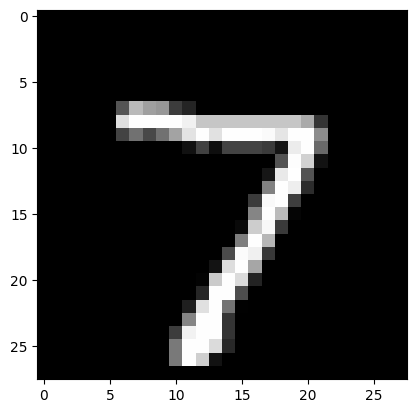

In [9]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [10]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 7
Ground truth is : 7


# PROFILING STARTS HERE

In [11]:
print(model)

ConvNet(
  (cn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (cn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (dp1): Dropout2d(p=0.1, inplace=False)
  (dp2): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [12]:
print(sample_data.shape)

torch.Size([500, 1, 28, 28])


## profile model inference on cpu

### cpu time

##### expand notebook to visualise traces properly

In [13]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [14]:
from torch.profiler import profile, record_function, ProfilerActivity

In [15]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(sample_data)

STAGE:2024-02-16 16:03:39 3073744:3073744 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-02-16 16:03:39 3073744:3073744 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-02-16 16:03:39 3073744:3073744 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [16]:
print(prof.key_averages().table(sort_by="cpu_time_total"))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        10.54%       4.908ms       100.00%      46.563ms      46.563ms             1  
                     aten::conv2d         1.98%     920.000us        51.67%      24.057ms      12.028ms             2  
                aten::convolution         0.19%      90.000us        49.69%      23.137ms      11.569ms             2  
               aten::_convolution         0.11%      52.000us        49.50%      23.047ms      11.524ms             2  
         aten::mkldnn_convolution        49.11%      22.865ms        49.38%      22.995ms      11.498ms             2  
                 aten::max_pool2d       

In [17]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total"))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                  model_inference        10.54%       4.908ms       100.00%      46.563ms      46.563ms             1                                                                                []  
                     aten::conv2d         0.03%      13.000us        36.59%      17.038ms      17.038ms             1                         [[500, 16, 26, 26], [32, 16, 3, 3], [32], [], [], 

### cpu memory

In [18]:
with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    model(sample_data)

print(prof.key_averages().table(sort_by="cpu_memory_usage"))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       aten::relu         0.44%     172.000us        14.70%       5.740ms       1.913ms      55.91 Mb           0 b             3  
                  aten::clamp_min        14.26%       5.568ms        14.26%       5.568ms       1.856ms      55.91 Mb      55.91 Mb             3  
                     aten::conv2d         0.06%      22.000us        59.51%      23.232ms      11.616ms      55.79 Mb           0 b             2  
                aten::convolution         0.20%      79.000us        59.45%      23.210ms      11.605ms      55.

STAGE:2024-02-16 16:03:39 3073744:3073744 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-02-16 16:03:39 3073744:3073744 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-02-16 16:03:39 3073744:3073744 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


### gpu time

In [19]:
model=model.cuda()
sample_data=sample_data.cuda()
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(sample_data)

print(prof.key_averages().table(sort_by="cuda_time_total"))

STAGE:2024-02-16 16:03:39 3073744:3073744 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.04%       1.189ms        99.94%        3.252s        3.252s       0.000us         0.00%       3.935ms       3.935ms             1  
                                           aten::conv2d         0.00%      27.000us        95.25%        3.099s        1.550s       0.000us         0.00%       3.024ms       1.512ms             2  
         

STAGE:2024-02-16 16:03:43 3073744:3073744 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-02-16 16:03:43 3073744:3073744 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


## tracing

In [20]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    model(sample_data)

prof.export_chrome_trace("trace.json")

STAGE:2024-02-16 16:03:43 3073744:3073744 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-02-16 16:03:43 3073744:3073744 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-02-16 16:03:43 3073744:3073744 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
